# Application of spatial aging clocks to interventions (rejuvenation and adverse)
This notebook contains code for applying the spatial aging clocks to datasets on rejuvenation and adverse interventions:
- Exercise MERFISH
- Partial reprogramming MERFISH
- Publicly available LPS MERFISH
- Publicly available Alzheimer's STARmap
- Publicly available ISS multiple sclerosis EAE model
- Publicly available demyelination injury

It also contains code for plotting the density of predicted age and heatmaps showing differences in predicted ages across different conditions.

**Associated manuscript figures/tables:**
- Figures: 2e; 3d,e,f,g,i,j
- Extended Data Figures: 8a,c,d,e,f,g
- Supplementary Table 12 (partial)


**Inputs required:**
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock.py`)
- `data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad` - AnnData object for exercise dataset
- `data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad` - AnnData object for reprogramming dataset
- assorted AnnData objects corresponding to external datasets from Allen et al. (2023), Zeng et al. (2023), Androvic et al. (2023), Kukanja et al. (2024) and reformatted according to steps in Methods section of manuscript 

**Conda environment used**: `requirements/merfish.txt`


In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, lasso_path, LinearRegression
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy.stats import mannwhitneyu, ttest_ind, ks_2samp
from decimal import Decimal

from clock_preprocessing import *
from clock_prediction import *

In [2]:
# CUSTOM Pink-Green colormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

# create colormap
# ---------------

# number of shades to cut in
cut_in = round(0.04*256)

# set side colormaps
upper = matplotlib.cm.PiYG_r(np.arange(256))

# create middle colormap
lower1 = np.ones((int(256/4),4))
lower2 = np.ones((int(256/4),4))
ulen = round(upper.shape[0]/2)
for i in range(3):
    lower1[:,i] = np.linspace(1, upper[ulen-cut_in,i], lower1.shape[0])
    lower2[:,i] = np.linspace(1, upper[ulen+cut_in,i], lower2.shape[0])

# combine parts of colormap
cmap = np.vstack((upper[:ulen-cut_in,:], lower1[::-1], lower2, upper[ulen+cut_in:,:]))

# convert to matplotlib colormap
cmap = matplotlib.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

In [3]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

celltype_palette = {'Neuron-Excitatory':'forestgreen',
                    'Neuron-Inhibitory':'lightgreen', 
                    'Neuron-MSN':'yellowgreen',
                    'Astrocyte': 'royalblue', 
                    'Microglia': 'aqua', 
                    'Oligodendrocyte': 'skyblue', 
                    'OPC': 'deepskyblue',
                    'Endothelial': 'red', 
                    'Pericyte': 'darkred', 
                    'VSMC': 'salmon', 
                    'VLMC': 'indianred',
                    'Ependymal': 'gray', 
                    'Neuroblast': 'sandybrown', 
                    'NSC':'darkorange', 
                    'Macrophage':'purple', 
                    'Neutrophil':'darkviolet',
                    'T cell':'magenta', 
                    'B cell':'orchid',
}

In [4]:
# function for bootstrap sampling for statistics
def bootstrap_median_difference (df1, df2, ci=0.95, num_boot=1000):
    '''
    Given two dataframes with mouse_id and pred_age as columns, computes bootstrap confidence interval.
    Bootstrap samples by mouse_id within each dataframe separately.
    Computes difference of medians df1-df2.
    Computes confidence interval for these differences.
    '''
    med_diffs = []
    for i in range(num_boot):
        
        boot_df1_stacks = []
        draw1 = np.random.choice(np.unique(df1["mouse_id"].values), len(np.unique(df1["mouse_id"].values)), replace=True)
        for d1 in draw1:
            boot_df1_stacks.append(df1[df1["mouse_id"]==d1].copy())
        
        boot_df2_stacks = []
        draw2 = np.random.choice(np.unique(df2["mouse_id"].values), len(np.unique(df2["mouse_id"].values)), replace=True)
        for d2 in draw2:
            boot_df2_stacks.append(df2[df2["mouse_id"]==d2].copy())
        
        boot_df1 = pd.concat(boot_df1_stacks)
        boot_df2 = pd.concat(boot_df2_stacks)
        med_diffs.append(boot_df1["pred_age"].median() - boot_df2["pred_age"].median())
    
    # confidence interval
    lower = np.quantile(med_diffs, 0.025)
    upper = np.quantile(med_diffs, 0.975)
    
    return((lower,upper))

## Exercise (MERFISH 300 genes)

In [4]:
adata = sc.read_h5ad("data/integrated_exercise_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
B cell
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
Neutrophil
OPC
Oligodendrocyte
Pericyte
T cell
VLMC
VSMC


In [6]:
# df.to_csv(f"results/clocks/applied/exercise_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/exercise_spatialsmooth.h5ad")

In [4]:
df = pd.read_csv(f"results/clocks/applied/exercise_spatialsmooth.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.42837413/ipykernel_39593/780995712.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


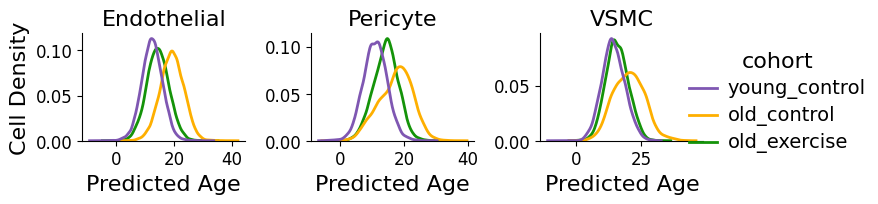

In [9]:
# Plot predicted age densities across select cell types

palette = {"young_control":"#7F57B2",
           "old_exercise":"#149309",
           "old_control":"#FEAF00"}

sub_df = df[df["celltype"].isin(["Endothelial","Pericyte","VSMC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

ncols = 3

g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["young_control", "old_control", "old_exercise"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/exercise/exercise_spatialsmooth_SUBSET.pdf", bbox_inches='tight')
plt.show()

In [7]:
# compute stats

celltypes = ["Endothelial","Pericyte","VSMC"]
comparisons = [["old_exercise", "old_control"],
               ["old_exercise", "young_control"],
               ["old_control", "young_control"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
-4.91
1.95
6.87
-3.4
3.4
6.8
-4.65
1.51
6.16

DIFF LOWER:
-7.67
0.0309
4.79
-6.52
1.32
1.62
-9.98
-1.11
1.6

DIFF UPPER:
-2.17
3.95
9.02
1.57
5.45
9.22
-0.177
4.26
11.3


/local/scratch/edsun/slrmtmp.42837413/ipykernel_39593/385130231.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")


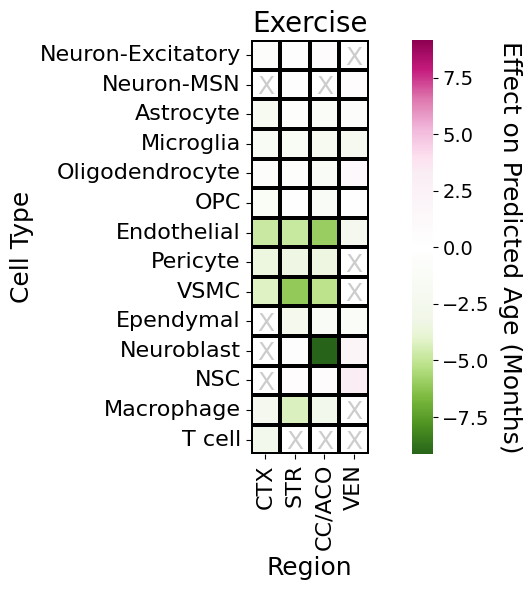

In [13]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]

region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = pd.unique(df["region_coarse"]).sort_values()
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)].copy()
        if sub_df[sub_df['cohort']=="old_exercise"].shape[0] < 50: # if less than certain number of cells in region+oldtreated group
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="old_exercise"]["pred_age"].median() - sub_df[sub_df['cohort']=="old_control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region_coarse"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region_coarse"] = start_df["region_coarse"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Exercise", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/exercise/exercise_spatialsmooth_heatmap_medians_REGIONED.pdf",
            bbox_inches='tight')
plt.show()

In [14]:
# Visualize spatial median diffs (for illustration only)

adata = sc.read_h5ad("results/clocks/anndata/exercise_spatialsmooth.h5ad")

In [15]:
# Compute median subtracted effects on predicted ages

coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]

effects_on_predicted_ages = np.zeros_like(adata.obs.predicted_age)

for ct in np.unique(adata.obs.celltype):
    for reg in np.unique(adata.obs.region_coarse):
        mask = (adata.obs.celltype==ct)&(adata.obs.region_coarse==reg)
        oc_median = np.median(adata[mask&(adata.obs.cohort=="old_control")].obs.predicted_age)
        effects_on_predicted_ages[mask] = adata[mask].obs.predicted_age-oc_median

adata.obs["effect_on_predicted_age"] = effects_on_predicted_ages

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/edsun/.conda/envs/merfish/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


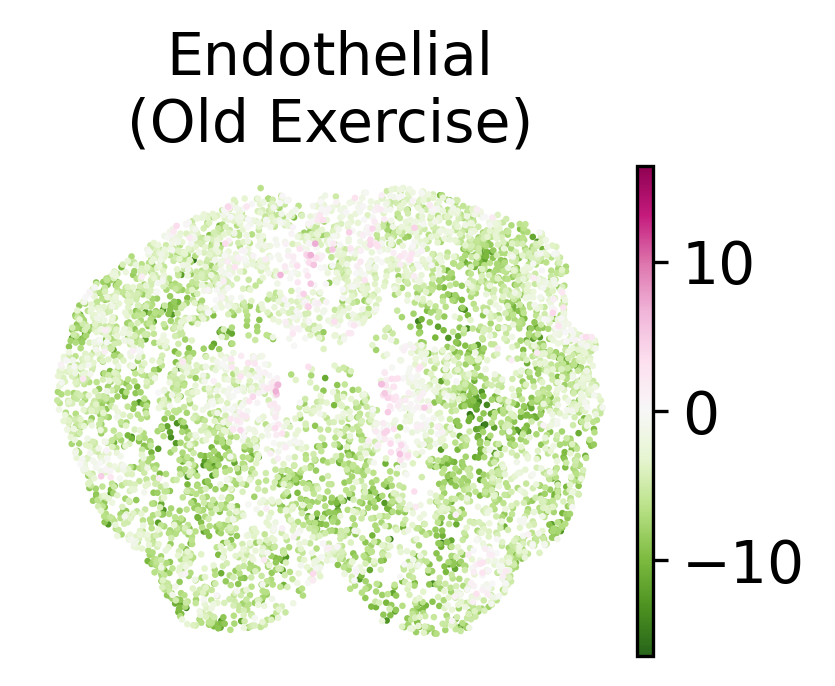

In [16]:
# Spatial visualization of one sample by intervention effect

#mids = ['OE1', 'OE2','OE3', 'OE4']
mid = 'OE1'
celltype = "Endothelial"

# -------------------------
sc.set_figure_params(dpi=150)
fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3,2.5))

sub_adata = adata[(adata.obs['mouse_id']==mid)&(adata.obs.celltype==celltype)]
sc.pl.embedding(sub_adata, 'spatial', color="effect_on_predicted_age", size=10, show=False,
                ax=axarr, title=f"{celltype}\n(Old Exercise)", cmap="PiYG_r",
                vmax=np.max(np.abs(sub_adata.obs.effect_on_predicted_age)),
                vmin=-np.max(np.abs(sub_adata.obs.effect_on_predicted_age)))
axarr.axis('off')

plt.tight_layout()
plt.savefig(f"plots/exercise/spatial_age_diff_global_{celltype}.pdf", bbox_inches='tight')
plt.show()

## Partial Reprogramming (MERFISH 300 genes)

In [20]:
adata = sc.read_h5ad("data/integrated_reprogramming_coronal_celltyped_regioned_raw.h5ad")
adata = adata[(adata.obs.clusters!="0")].copy()

In [21]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name)

Astrocyte
Endothelial
Ependymal
Macrophage
Microglia
NSC
Neuroblast
Neuron-Excitatory
Neuron-Inhibitory
Neuron-MSN
OPC
Oligodendrocyte
Pericyte
VLMC
VSMC


In [22]:
# df.to_csv(f"results/clocks/applied/reprogramming_spatialsmooth.csv")
# adata.write_h5ad("results/clocks/anndata/reprogramming_spatialsmooth.h5ad")

In [8]:
df = pd.read_csv(f"results/clocks/applied/reprogramming_spatialsmooth.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

In [9]:
# correct for difference in ages between treatment and control
mean_oc_age = np.mean(np.unique(df[df.cohort=="old_notreatment"].age))
mean_ot_age = np.mean(np.unique(df[df.cohort=="old_treatment"].age))
print(mean_oc_age)
print(mean_ot_age)

pred_ages = df["pred_age"].values.copy()
pred_ages[df.cohort=="old_notreatment"] += (mean_ot_age-mean_oc_age)
df["pred_age"] = pred_ages

27.425
27.724999999999998


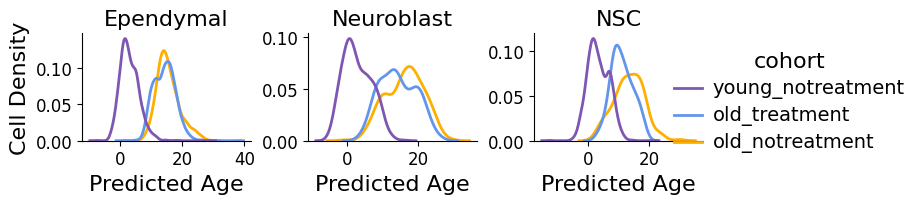

In [26]:
# SUBSET TOP 3

palette = {"young_notreatment":"#7F57B2",
           "old_treatment":"cornflowerblue", # #149309
           "old_notreatment":"#FEAF00"}

sub_df = df[df["celltype"].isin(["Ependymal","Neuroblast","NSC"])].copy()
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

ncols = 3
g = sns.displot(data=sub_df, x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=6/ncols, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["young_notreatment", "old_treatment", "old_notreatment"], linewidth=2,
            common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/reprogramming/reprogramming_spatialsmooth_SUBSET.pdf", bbox_inches='tight')
plt.show()

In [10]:
# compute stats

celltypes = ["Ependymal","Neuroblast","NSC"]
comparisons = [["old_treatment", "old_notreatment"],
               ["old_treatment", "young_notreatment"],
               ["old_notreatment", "young_notreatment"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df[df["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
-0.49
11.8
12.3
-2.81
11.4
14.2
-2.72
7.87
10.6

DIFF LOWER:
-2.9
8.61
9.17
-7.54
6.21
6.18
-7.25
3.4
4.03

DIFF UPPER:
1.87
13.9
14.1
6.88
18.6
18.5
3.26
12.1
14.5


/local/scratch/edsun/slrmtmp.42837413/ipykernel_41602/3180687438.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")


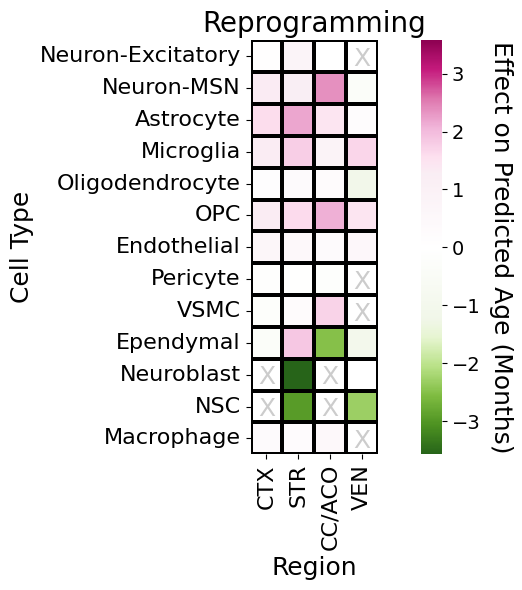

In [30]:
# define coarse regions
coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]

region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = pd.unique(df["region_coarse"]).sort_values()
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)].copy()
        if sub_df[sub_df['cohort']=="old_treatment"].shape[0] < 50: # if less than certain number of cells in region+oldtreated group
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="old_treatment"]["pred_age"].median() - sub_df[sub_df['cohort']=="old_notreatment"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region_coarse"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region_coarse"] = start_df["region_coarse"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region_coarse", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Reprogramming", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/reprogramming/reprogramming_spatialsmooth_heatmap_medians_REGIONED.pdf",
            bbox_inches='tight')
plt.show()

In [31]:
# Visualize spatial median diffs (for illustration only)

adata = sc.read_h5ad("results/clocks/anndata/reprogramming_spatialsmooth.h5ad")

In [32]:
# correct for difference in ages
mean_oc_age = np.mean(np.unique(adata.obs[adata.obs.cohort=="old_notreatment"].age))
mean_ot_age = np.mean(np.unique(adata.obs[adata.obs.cohort=="old_treatment"].age))
print(mean_oc_age)
print(mean_ot_age)

pred_ages = adata.obs["predicted_age"].values.copy()
pred_ages[adata.obs.cohort=="old_notreatment"] += (mean_ot_age-mean_oc_age)
adata.obs["predicted_age"] = pred_ages

27.425
27.724999999999998


In [33]:
# Compute median subtracted effects on predicted ages

coarse_region_mapping = {
    "CC/ACO":"CC/ACO",
    "CTX_L1/MEN":"CTX",
    "CTX_L2/3":"CTX",
    "CTX_L4/5/6":"CTX",
    "STR_CP/ACB":"STR",
    "STR_LS/NDB":"STR",
    "VEN":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]

effects_on_predicted_ages = np.zeros_like(adata.obs.predicted_age)

for ct in np.unique(adata.obs.celltype):
    for reg in np.unique(adata.obs.region_coarse):
        mask = (adata.obs.celltype==ct)&(adata.obs.region_coarse==reg)
        oc_median = np.median(adata[mask&(adata.obs.cohort=="old_notreatment")].obs.predicted_age)
        effects_on_predicted_ages[mask] = adata[mask].obs.predicted_age-oc_median

adata.obs["effect_on_predicted_age"] = effects_on_predicted_ages

/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/edsun/.conda/envs/merfish/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/edsun/.conda/envs/merfish/li

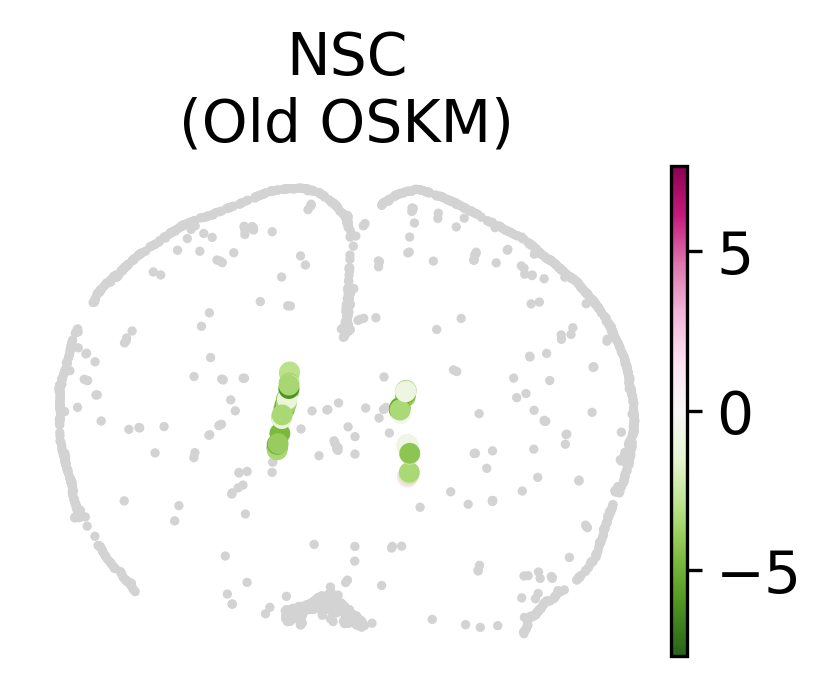

In [34]:
# Spatial visualization of intervention effect

#mids = ['OT1084', 'OT1125','OT1160', 'OT902']
mid = 'OT902'
celltype = "NSC"

white_celltype = "VLMC"

# -------------------------

sc.set_figure_params(dpi=150)
fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3,2.5))
sub_adata = adata[(adata.obs['mouse_id']==mid)&(adata.obs.celltype.isin([celltype,white_celltype]))].copy()
sc.pl.embedding(sub_adata[sub_adata.obs.celltype==white_celltype], 'spatial', size=20, show=False,
                ax=axarr)
sc.pl.embedding(sub_adata[sub_adata.obs.celltype==celltype], 'spatial', color="effect_on_predicted_age", size=100, show=False,
                ax=axarr, title=f"{celltype}\n(Old OSKM)", cmap="PiYG_r", sort_order=False,
                vmax=np.nanmax(np.abs(sub_adata[sub_adata.obs.celltype==celltype].obs.effect_on_predicted_age)),
                vmin=-np.nanmax(np.abs(sub_adata[sub_adata.obs.celltype==celltype].obs.effect_on_predicted_age)))
axarr.axis('off')
plt.tight_layout()
plt.savefig(f"plots/reprogramming/spatial_age_diff_global_oskm_{celltype}.pdf", bbox_inches='tight')
plt.show()

## LPS (MERFISH from Allen et al. (2023))

#### Apply clocks

In [4]:
adata = sc.read_h5ad("data/allen_2022_aging_merfish/merfish_combined_processed.h5ad")
adata.obs["region"] = adata.obs.tissue.copy()

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, normalize=False, standardize=False, fill_missing="spage")

Astrocyte
Imputing values for 225 missing genes
Endothelial
Imputing values for 225 missing genes
Macrophage
Imputing values for 225 missing genes
Microglia
Imputing values for 225 missing genes
Neuron-Excitatory
Imputing values for 225 missing genes
Neuron-Inhibitory
Imputing values for 225 missing genes
Neuron-MSN
Imputing values for 225 missing genes
OPC
Imputing values for 225 missing genes
Oligodendrocyte
Imputing values for 225 missing genes
Pericyte
Imputing values for 225 missing genes
T cell
Imputing values for 225 missing genes
VLMC
Imputing values for 225 missing genes
other


In [12]:
# df.to_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_spage.csv")
# adata.write_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad")

In [10]:
df = pd.read_csv(f"results/clocks/applied/allen_aging_lps_spatialsmooth_spage.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

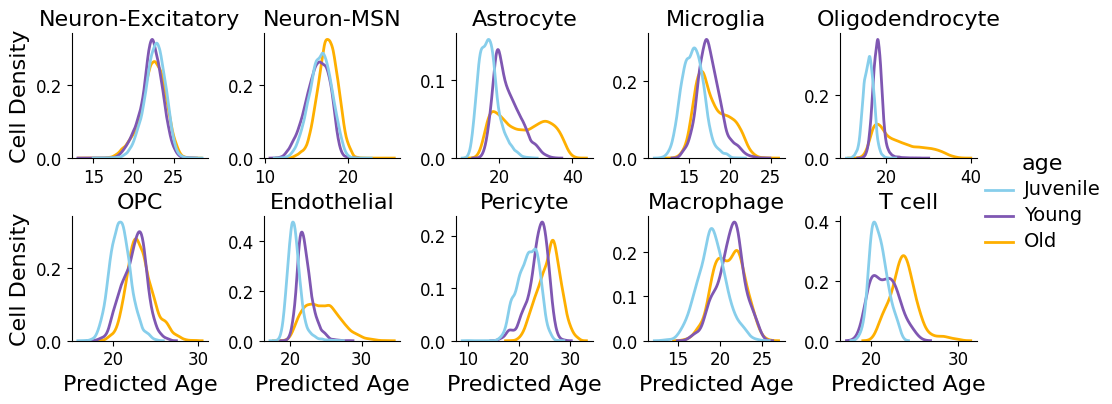

In [11]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)

df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

palette = {"Young":"#7F57B2",
           "Juvenile":"#87CEEB",
           "Old":"#FEAF00"}

ncols = 5
g = sns.displot(data=df_aging, x="pred_age", hue="age", col="celltype", kind="kde", col_wrap=ncols, height=10/ncols, aspect=1,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            hue_order=["Juvenile", "Young", "Old"], linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/allen_aging_spatialsmooth_spage.pdf", bbox_inches='tight')
plt.show()

In [ ]:
df_aging = df[df['cohort']=="aging"].copy()
df_aging['age'] = df_aging['age'].astype(str)
df_aging['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df_aging['age']]

# compute stats

celltypes = ["Neuron-Excitatory", "Neuron-MSN", "Astrocyte", "Microglia",
             "Oligodendrocyte", "OPC", "Endothelial", "Pericyte",
             "Macrophage", "T cell"]
comparisons = [["Old", "Juvenile"],
               ["Old", "Young"],
               ["Young", "Juvenile"]]
cond_label = "age"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_aging[df_aging["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

/local/scratch/edsun/slrmtmp.43832397/ipykernel_74195/1899276649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


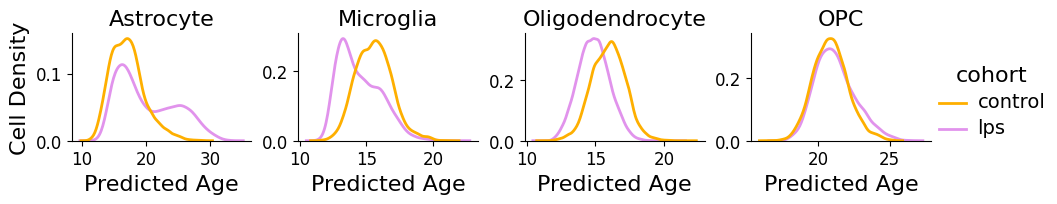

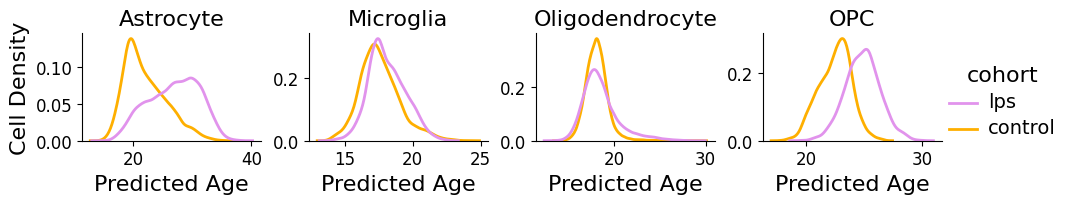

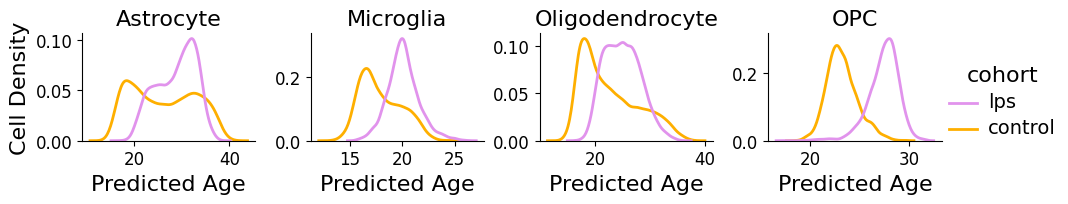

In [8]:
# TOP 4 SUBSET

sub_df = df[df["celltype"].isin(["Astrocyte","Microglia","Oligodendrocyte","OPC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

for age in np.unique(sub_df['age']):
    df_lps = sub_df[sub_df['age']==age].copy()
    df_lps = df_lps.replace('aging', 'control')

    palette = {"control":"#FEAF00",
           "lps":"#E193EC"} # #E193EC

    ncols = 4
    g = sns.displot(data=df_lps[df_lps['age']==age], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
                facet_kws={'sharey': False, 'sharex': False}, palette=palette,
                linewidth=2, common_norm=False)
    for ax in g.axes.flat:
        ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
        if ax.get_xlabel() != "":
            ax.set_xlabel("Predicted Age", fontsize=16)
        if ax.get_ylabel() != "":
            ax.set_ylabel("Cell Density", fontsize=16)
        ax.tick_params(which='major', labelsize=12)

    g.legend.get_title().set_size(16)
    for label in g.legend.get_texts():
        label.set_size(14)

    plt.savefig(f"plots/clocks/allen_lps{round(float(age))}_spatialsmooth_spage_SUBSET.pdf")
    plt.show()

In [14]:
# compute stats

df_lps = df[df['age']==20.93]

celltypes = ["Astrocyte","Microglia","Oligodendrocyte","OPC"]
comparisons = [["lps", "aging"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_lps[df_lps["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
3.68
2.47
3.51
4.56

DIFF LOWER:
0.478
1.77
1.46
3.69

DIFF UPPER:
7.44
3.04
5.49
5.15


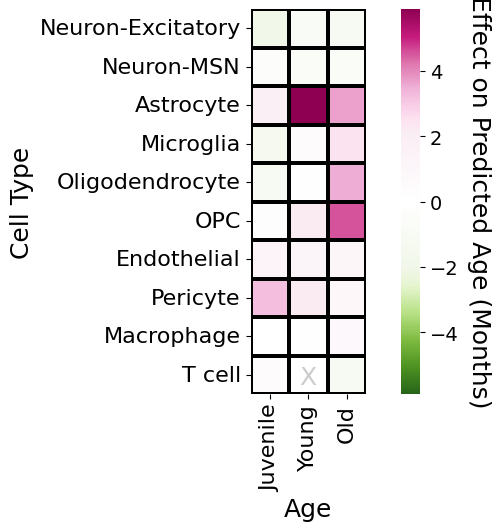

In [9]:
# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df["celltype"]).sort_values()
median_ages_diffs = []

df['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[str(x)] for x in df['age']]

for age in ['Juvenile', 'Young', 'Old']:
    int_col = []
    for ct in celltypes:
        sub_df = df[(df['celltype']==ct)&(df['age']==age)].copy()
        sub_df = sub_df.replace('aging', 'control')
        if sub_df[sub_df['cohort']=="lps"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="lps"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        int_col.append(median_age_diff)
    median_ages_diffs.append(int_col)

pivot_df = pd.DataFrame(np.array(median_ages_diffs).T, columns=['Juvenile', 'Young', 'Old'],
                       index=celltypes)


# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,5))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)


plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Age", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("plots/clocks/allen_aging_spatialsmooth_spage_heatmap_medians.pdf",
            bbox_inches='tight')
plt.show()

/local/scratch/edsun/slrmtmp.43332625/ipykernel_26733/924338530.py:50: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


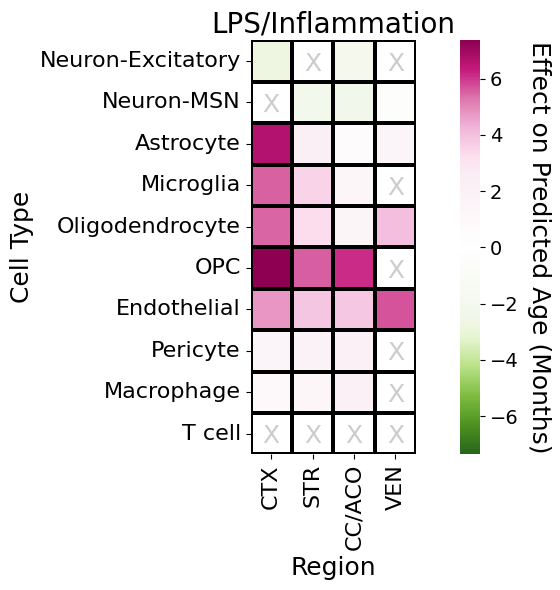

In [11]:
# OLD region-specific intervention effect


coarse_region_mapping = {
    "corpus callosum":"CC/ACO",
    "olfactory region":"CC/ACO",
    "cortical layer II/III":"CTX",
    "cortical layer V":"CTX",
    "cortical layer VI":"CTX",
    "pia mater":"CTX",
    "striatum":"STR",
    "brain ventricle":"VEN",
}

df["region_coarse"] = [coarse_region_mapping[x] for x in df.region]
#df['age'] = df['age'].astype(str)
#df['age'] = [{'0.93':'Juvenile','5.58':'Young','20.93':'Old'}[x] for x in df['age']]


# fingerprint heatmap
effect_cutoff = 0


region_order = ['CTX', 'STR', 'CC/ACO', 'VEN']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region_coarse"] = df["region_coarse"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region_coarse"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region_coarse']==reg)&(df['age']=='Old')].copy()
        sub_df = sub_df.replace('aging', 'control')
        if sub_df[sub_df['cohort']=="lps"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="lps"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("LPS/Inflammation", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/allen_spatialsmooth_heatmap_medians_REGIONED_Old.pdf",
            bbox_inches='tight')
plt.show()

In [6]:
# Visualize spatial median diffs (for illustration only)

adata = sc.read_h5ad("results/clocks/anndata/allen_aging_lps_spatialsmooth_spage.h5ad")
adata = adata[adata.obs.age==20.93]

In [17]:
# Compute median subtracted effects on predicted ages

coarse_region_mapping = {
    "corpus callosum":"CC/ACO",
    "olfactory region":"CC/ACO",
    "cortical layer II/III":"CTX",
    "cortical layer V":"CTX",
    "cortical layer VI":"CTX",
    "pia mater":"CTX",
    "striatum":"STR",
    "brain ventricle":"VEN",
}

adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]

effects_on_predicted_ages = np.zeros_like(adata.obs.predicted_age)

for ct in np.unique(adata.obs.celltype):
    for reg in np.unique(adata.obs.region_coarse):
        mask = (adata.obs.celltype==ct)&(adata.obs.region_coarse==reg)
        oc_median = np.median(adata[mask&(adata.obs.cohort=="aging")].obs.predicted_age)
        effects_on_predicted_ages[mask] = adata[mask].obs.predicted_age-oc_median

adata.obs["effect_on_predicted_age"] = effects_on_predicted_ages

/local/scratch/edsun/slrmtmp.42222836/ipykernel_44830/1181119088.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["region_coarse"] = [coarse_region_mapping[x] for x in adata.obs.region]


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


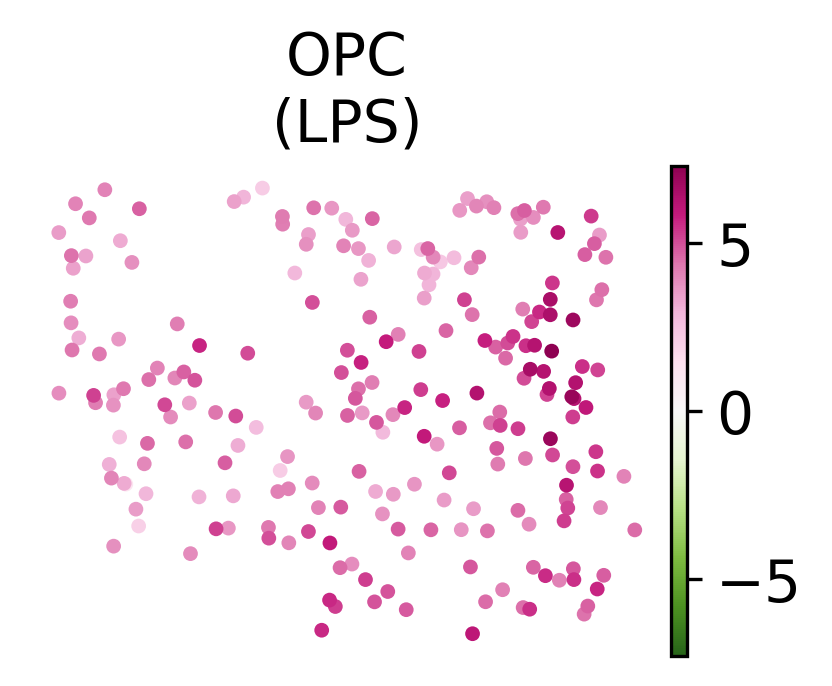

In [19]:
# Spatial visualization

mid = 'MsBrainAgingSpatialDonor_19_0'
celltype = "OPC"

# -------------------------
sc.set_figure_params(dpi=150)
fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3,2.5))
sub_adata = adata[(adata.obs['mouse_id']==mid)&(adata.obs.celltype==celltype)]
sc.pl.embedding(sub_adata, 'spatial', color="effect_on_predicted_age", size=50, show=False,
                ax=axarr, title=f"{celltype}\n(LPS)", cmap="PiYG_r",
                vmax=np.max(np.abs(sub_adata.obs.effect_on_predicted_age)),
                vmin=-np.max(np.abs(sub_adata.obs.effect_on_predicted_age)))
axarr.axis('off')
plt.tight_layout()
plt.savefig(f"plots/clocks/spatial_age_diff_global_allenLPS_{celltype}.pdf", bbox_inches='tight')
plt.show()

## Alzheimers (STARmap from Zeng et al. (2023))

Dataset is 8 mice -- balanced between control and disease and ages 8mo and 13mo

#### Apply clocks

In [13]:
adata = sc.read_h5ad("data/zeng_2023_alzheimer_starmap/starmap_AD_processed.h5ad")
adata.obsm['spatial'] = adata.obs[["X","Y"]].values
adata.obs["region"] = adata.obs.region_merged.copy()

In [14]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

Astrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
Endothelial


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 128 missing genes


In [15]:
# df.to_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_spage.csv")
# adata.write_h5ad("results/clocks/anndata/zeng_starmapAD_spatialsmooth_spage.h5ad")

In [15]:
df = pd.read_csv(f"results/clocks/applied/zeng_starmapAD_spatialsmooth_spage.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.42091567/ipykernel_20952/2177315823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()


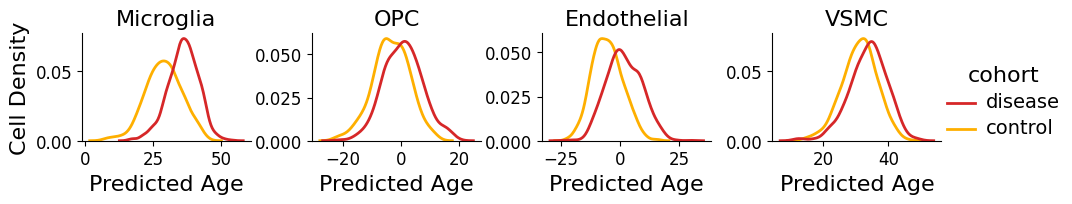

In [20]:
# TOP 4 SUBSET (13 months)

sub_df = df[df["celltype"].isin(["Microglia","OPC","Endothelial","VSMC"])]
sub_df["celltype"] = sub_df["celltype"].cat.remove_unused_categories()

palette = {"control":"#FEAF00", # #935E09
           "disease":"tab:red"}
ncols = 4
g = sns.displot(data=sub_df[sub_df['age']==13], x="pred_age", hue="cohort", col="celltype", kind="kde", col_wrap=ncols, height=2, aspect=1.2,
            facet_kws={'sharey': False, 'sharex': False}, palette=palette,
            linewidth=2, common_norm=False)
for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().split(' = ')[1], fontsize=16)
    if ax.get_xlabel() != "":
        ax.set_xlabel("Predicted Age", fontsize=16)
    if ax.get_ylabel() != "":
        ax.set_ylabel("Cell Density", fontsize=16)
    ax.tick_params(which='major', labelsize=12)

g.legend.get_title().set_size(16)
for label in g.legend.get_texts():
    label.set_size(14)

plt.savefig("plots/clocks/zeng_spatialsmooth_spage_13mo_SUBSET.pdf", bbox_inches='tight')
plt.show()

In [16]:
df_ad = df[df['age']==13]


celltypes = ["Microglia","OPC","Endothelial","VSMC"]
comparisons = [["disease", "control"]]
cond_label = "cohort"

#----------------------------------------

cell_pvalues = []
animal_pvalues = []
diff_med_preds = []
diff_med_lowers = []
diff_med_uppers = []

for ct in celltypes:
    
    # subset cell type
    sub_df = df_ad[df_ad["celltype"]==ct]
    
    # get animal-level median predicted ages
    median_predicted_ages = []
    groups = []
    for mid in np.unique(sub_df['mouse_id']):
        median_predicted_ages.append(sub_df[sub_df['mouse_id']==mid]["pred_age"].median())
        groups.append(sub_df[sub_df['mouse_id']==mid][cond_label].values[0])
    sub_cond_df = pd.DataFrame([])
    sub_cond_df["Median Predicted Age"] = median_predicted_ages
    sub_cond_df["Condition"] = groups

    # get stats for each comparison
    for comparison in comparisons:
        
        # difference in median predicted ages
        median_age_diff = sub_df[sub_df[cond_label]==comparison[0]]["pred_age"].median() - sub_df[sub_df[cond_label]==comparison[1]]["pred_age"].median()
        diff_med_preds.append(median_age_diff)
        
        ci = bootstrap_median_difference(sub_df[sub_df[cond_label]==comparison[0]], sub_df[sub_df[cond_label]==comparison[1]])
        diff_med_lowers.append(ci[0])
        diff_med_uppers.append(ci[1])
        
        # cell-level
        u, p = mannwhitneyu(sub_df[sub_df[cond_label]==comparison[0]]["pred_age"],
                            sub_df[sub_df[cond_label]==comparison[1]]["pred_age"])
        cell_pvalues.append(p)
        
        # animal-level
        u2, p2 = mannwhitneyu(sub_cond_df[sub_cond_df["Condition"]==comparison[0]]["Median Predicted Age"],
                            sub_cond_df[sub_cond_df["Condition"]==comparison[1]]["Median Predicted Age"])
        animal_pvalues.append(p2)
        
# PRINT RESULTS
print("DIFF:")
for x in diff_med_preds:
    print(f'{x:.3}')

print("\nDIFF LOWER:")
for x in diff_med_lowers:
    print(f'{x:.3}')
    
print("\nDIFF UPPER:")
for x in diff_med_uppers:
    print(f'{x:.3}')

DIFF:
7.45
3.87
6.93
2.96

DIFF LOWER:
4.67
2.34
2.91
0.56

DIFF UPPER:
11.1
5.66
11.4
5.75


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


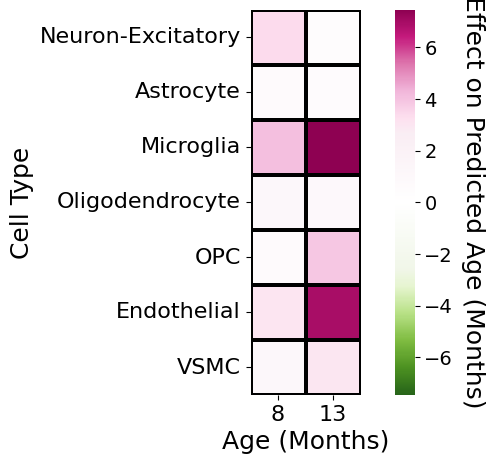

In [85]:
# fingerprint heatmap
effect_cutoff = 0

celltypes = pd.unique(df['celltype']).sort_values()
median_ages_diffs = []

for age in np.unique(df['age']):
    int_col = []
    for ct in celltypes:
        sub_df = df[(df['celltype']==ct)&(df['age']==age)].copy()
        if sub_df[sub_df['cohort']=="disease"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="disease"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        int_col.append(median_age_diff)
    median_ages_diffs.append(int_col)

pivot_df = pd.DataFrame(np.array(median_ages_diffs).T, columns=np.unique(df['age']).astype(int).astype(str),
                       index=celltypes)

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,5))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.max(np.abs(median_ages_diffs)),
            vmax=np.max(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)


plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Age (Months)", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig("plots/clocks/zeng_spatialsmooth_spage_heatmap_medians.pdf",
            bbox_inches='tight')
plt.show()

/local/scratch/edsun/slrmtmp.42221467/ipykernel_40943/988599570.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


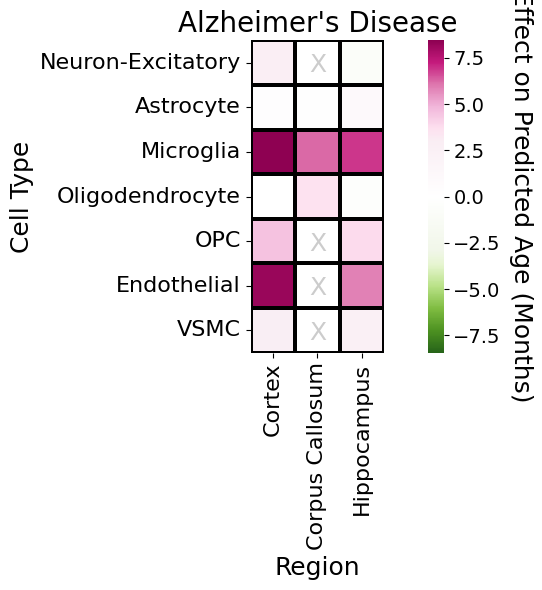

In [86]:
# fingerprint heatmap
effect_cutoff = 0

region_order = ['Cortex', 'Corpus Callosum', 'Hippocampus']

celltypes = pd.unique(df["celltype"]).sort_values()
df["region"] = df["region"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region']==reg)&(df['age']==13)].copy()
        if sub_df[sub_df['cohort']=="disease"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="disease"]["pred_age"].median() - sub_df[sub_df['cohort']=="control"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Alzheimer's Disease", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/zeng_spatialsmooth_heatmap_medians_REGIONED_13mo.pdf",
            bbox_inches='tight')
plt.show()

In [20]:
# Visualize spatial median diffs (for illustration only)

adata = sc.read_h5ad("results/clocks/anndata/zeng_starmapAD_spatialsmooth_spage.h5ad")
adata = adata[adata.obs.age==13]

In [69]:
# Compute median subtracted effects on predicted ages


adata.obs["region_coarse"] = adata.obs.region

effects_on_predicted_ages = np.zeros_like(adata.obs.predicted_age)

for ct in np.unique(adata.obs.celltype):
    for reg in np.unique(adata.obs.region_coarse):
        mask = (adata.obs.celltype==ct)&(adata.obs.region_coarse==reg)
        oc_median = np.median(adata[mask&(adata.obs.cohort=="control")].obs.predicted_age)
        effects_on_predicted_ages[mask] = adata[mask].obs.predicted_age-oc_median

adata.obs["effect_on_predicted_age"] = effects_on_predicted_ages

/local/scratch/edsun/slrmtmp.42199160/ipykernel_45070/1965911991.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["region_coarse"] = adata.obs.region


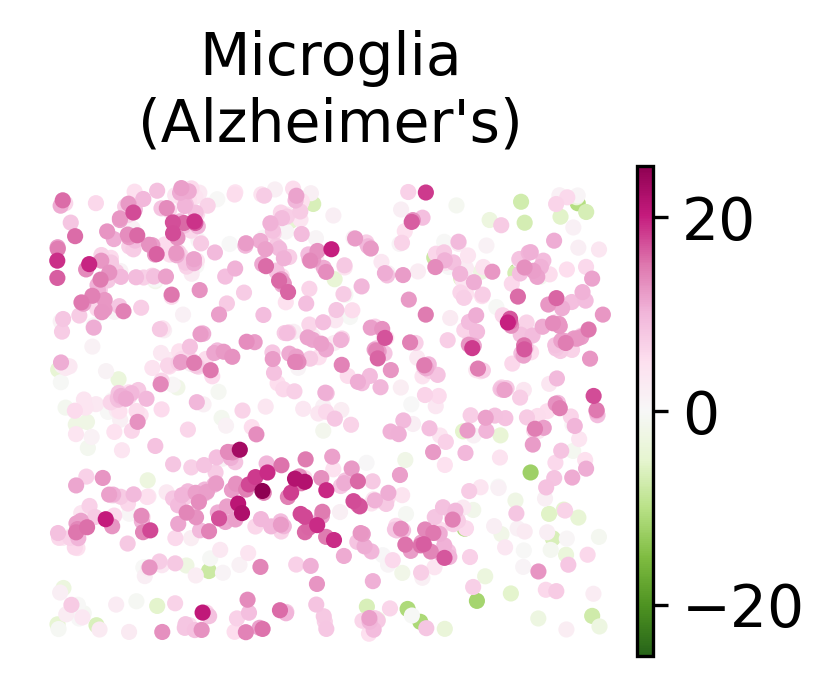

In [74]:
#mids = ['ADmouse_11346', 'ADmouse_9494']
mid = 'ADmouse_9494'
celltype = "Microglia"

# -------------------------
sc.set_figure_params(dpi=150)
fig, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3,2.5))
sub_adata = adata[(adata.obs['mouse_id']==mid)&(adata.obs.celltype==celltype)]
sc.pl.embedding(sub_adata, 'spatial', color="effect_on_predicted_age", size=60, show=False,
                ax=axarr, title=f"{celltype}\n(Alzheimer's)", cmap="PiYG_r",
                vmax=np.max(np.abs(sub_adata.obs.effect_on_predicted_age)),
                vmin=-np.max(np.abs(sub_adata.obs.effect_on_predicted_age)))
axarr.axis('off')
plt.tight_layout()
plt.savefig(f"plots/clocks/spatial_age_diff_global_starmapAD_{celltype}.pdf", bbox_inches='tight')
plt.show()

## Kukanja et al. (2024) - Multiple sclerosis (EAE mouse)

In [34]:
adata = sc.read_h5ad("data/kukanja_EAE_MS_2024/ISS_EAE_multiple_sclerosis_processed.h5ad")

In [35]:
adata.X = adata.X.toarray()

In [36]:
# Exclude certain cell types due to SpaGE algorithm instability
unstable_celltypes = ['Astrocyte', 'Endothelial', 'Ependymal', 'Oligodendrocyte', 'T cell', 'VLMC']
sub_adata = adata[~adata.obs.celltype.isin(unstable_celltypes)].copy()

In [37]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(sub_adata, clock_obj_name=name, fill_missing="spage")

DC
Macrophage


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Monocyte
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
OPC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Pericyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputing values for 240 missing genes
Schw
VC


In [38]:
# transfer predictions from subset
adata.obs["predicted_age"] = np.nan
adata.obs["predicted_age"][~adata.obs.celltype.isin(unstable_celltypes)] = sub_adata.obs.predicted_age

/local/scratch/edsun/slrmtmp.42772799/ipykernel_29011/53659948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["predicted_age"][~adata.obs.celltype.isin(unstable_celltypes)] = sub_adata.obs.predicted_age


In [39]:
# df.to_csv(f"results/clocks/applied/kukanja_ISSMS_spatialsmooth_spage.csv")
# adata.write_h5ad("results/clocks/anndata/kukanja_ISSMS_spatialsmooth_spage.h5ad")

In [17]:
df = pd.read_csv(f"results/clocks/applied/kukanja_ISSMS_spatialsmooth_spage.csv")
df = df[df['celltype'].isin(restricted_celltype_subset)]
df["celltype"] = df["celltype"].astype('category').cat.reorder_categories([x for x in restricted_celltype_subset if x in df['celltype'].values])
df = df.sort_values(by="celltype")

/local/scratch/edsun/slrmtmp.42772799/ipykernel_29011/360339447.py:31: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot_df = start_df.pivot("celltype", "region", "age_diff")


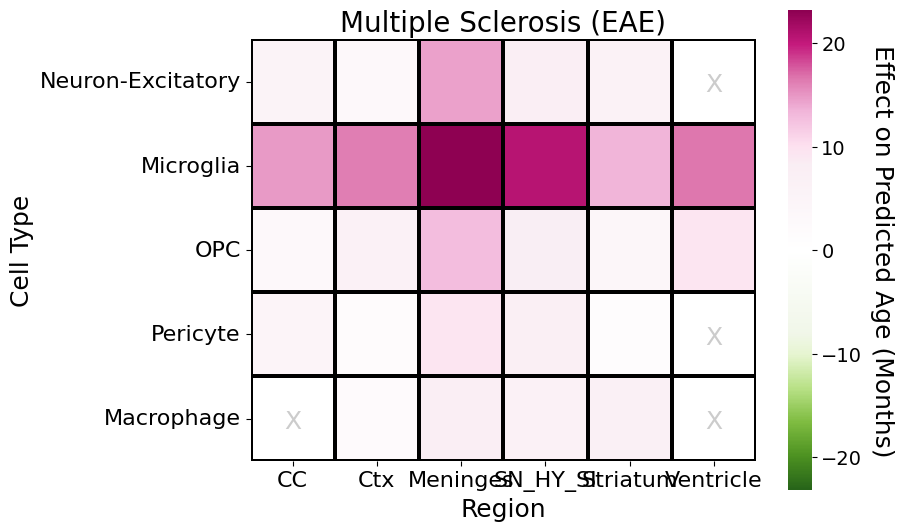

In [42]:
# fingerprint heatmap
effect_cutoff = 0

region_order = ['CC', 'Ctx', 'Meninges', 'SN_HY_SI', 'Striatum', 'Ventricle']
df = df[df["region"].isin(region_order)]
#df["region"] = df["region"].astype(str)

celltypes = pd.unique(df["celltype"]).sort_values()
df["region"] = df["region"].astype('category').cat.reorder_categories(region_order)
regions = np.unique(df["region"])
median_ages_diffs = []
ct_col = []
reg_col = []

for ct in celltypes:
    for reg in regions:
        sub_df = df[(df['celltype']==ct)&(df['region']==reg)].copy()
        if sub_df[sub_df['cohort']=="EAE"].shape[0] < 50:
            median_age_diff = np.nan
        else:
            median_age_diff = sub_df[sub_df['cohort']=="EAE"]["pred_age"].median() - sub_df[sub_df['cohort']=="CNTRL"]["pred_age"].median()
        median_ages_diffs.append(median_age_diff)
        ct_col.append(ct)
        reg_col.append(reg)

start_df = pd.DataFrame(np.vstack((ct_col, median_ages_diffs, reg_col)).T,
                        columns=["celltype", "age_diff", "region"])
start_df["age_diff"] = start_df["age_diff"].astype(float)
start_df["celltype"] = start_df["celltype"].astype('category').cat.reorder_categories(celltypes)
start_df["region"] = start_df["region"].astype('category').cat.reorder_categories(region_order)
pivot_df = start_df.pivot("celltype", "region", "age_diff")

# make figure
pivot_df = pivot_df.mask(np.abs(pivot_df.values)<effect_cutoff)
fig, ax = plt.subplots(figsize=(9,6))

# set X mask for NaN values
sns.heatmap(
    np.where(pivot_df.isna(), 0, np.nan),
    square=True,
    cbar=False,
    annot=np.full_like(pivot_df, "X", dtype=object),
    fmt="",
    annot_kws={"size": 18, "va": "center_baseline", "color": "0.8"},
    cmap=ListedColormap(['none']),
    linewidth=0, ax=ax)

# make colored heatmap
sns.heatmap(pivot_df, ax=ax, square=True, cmap=cmap,
            vmin=-np.nanmax(np.abs(median_ages_diffs)),
            vmax=np.nanmax(np.abs(median_ages_diffs)),
            linewidths=1.5, linecolor='k')

ax.collections[1].colorbar.set_label('Effect on Predicted Age (Months)',
                                    rotation=270, fontsize=18, labelpad=23)
ax.collections[1].colorbar.ax.tick_params(labelsize=14)

plt.title("Multiple Sclerosis (EAE)", fontsize=20)
plt.ylabel("Cell Type", fontsize=18)
plt.xlabel("Region", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("plots/clocks/kukanja_spatialsmooth_heatmap_medians_REGIONED.pdf",
            bbox_inches='tight')
plt.show()

## Androvic et al. (2023) - Brain injury MERFISH

In [8]:
adata = sc.read_h5ad("data/androvic_2023_injury_merfish/merfish_injury_processed.h5ad")

In [9]:
# Geometric rotation and labeling of two halves of the brain

def rotate(p, origin=(0, 0), degrees=0):
    
    # rigid rotation by degrees around origin
    
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

rotation_dict = {
    'b2s20':188, 'b3s20':130, 'b4s8':255
}



# --------------------------

new_spatial = adata.obsm['spatial'].copy()
cohorts = adata.obs.cohort.copy().astype(str)

for ii in np.unique(adata.obs["replicate"]):
    sub_adata = adata[adata.obs.replicate==ii]
    
    # center
    sub_adata.obsm["spatial"] = sub_adata.obsm["spatial"]-np.mean(sub_adata.obsm["spatial"],axis=0)
    
    # rotate
    sub_adata.obsm["spatial"] = rotate(sub_adata.obsm["spatial"],
                                      degrees=360-rotation_dict[ii])    
    
    # update coords
    new_spatial[adata.obs.replicate==ii,:] = sub_adata.obsm["spatial"]

adata.obsm["spatial"] = new_spatial
    
# Label cohorts by brain halves
cohorts[adata.obsm["spatial"][:,0]<0] = "Left (Injury)"
cohorts[adata.obsm["spatial"][:,0]>=0] = "Right (Control)"
adata.obs.cohort = cohorts.astype('category')

b2s20


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


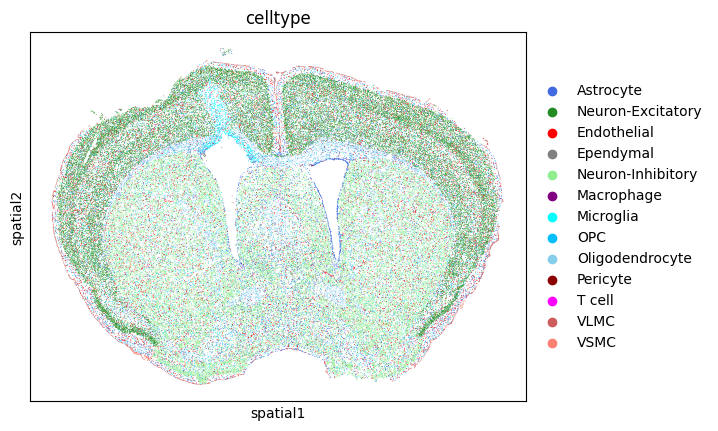

b3s20


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


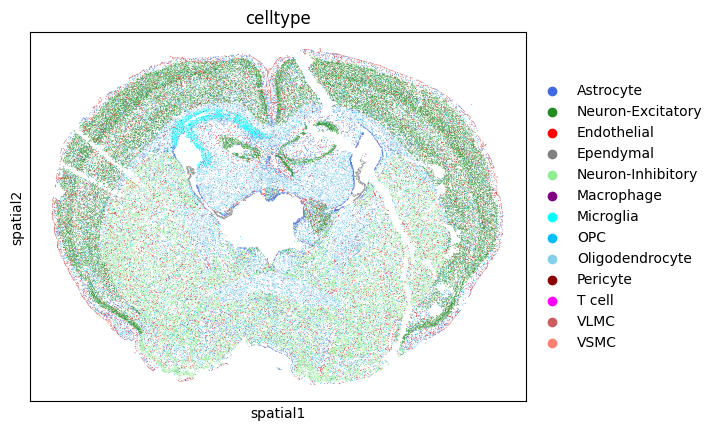

b4s8


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


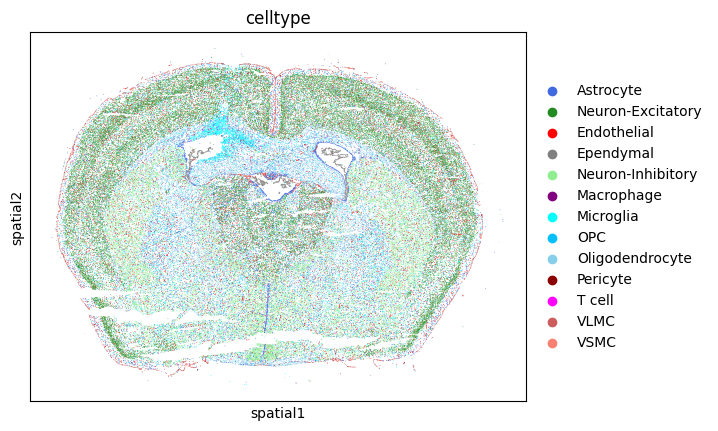

In [12]:
for mid in np.unique(adata.obs.mouse_id):
    print(mid)
    sc.pl.embedding(adata[(adata.obs.mouse_id==mid)&(adata.obs.celltype!="doublet")&(adata.obs.celltype!="Other")], "spatial", color="celltype", palette=celltype_palette)

In [32]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = get_predictions(adata, clock_obj_name=name, fill_missing="spage")

Astrocyte
Imputed values for 236 missing genes
Endothelial
Imputed values for 236 missing genes
Ependymal


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
Macrophage
Imputed values for 236 missing genes
Microglia


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
Neuron-Excitatory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
Neuron-Inhibitory


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
OPC
Imputed values for 236 missing genes
Oligodendrocyte


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
Other
Pericyte
Imputed values for 236 missing genes
T cell
Imputed values for 236 missing genes
VLMC
Imputed values for 236 missing genes
VSMC


/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Imputed values for 236 missing genes
doublet


In [33]:
# df.to_csv(f"results/clocks/applied/androvic_injuryMERFISH_spatialsmooth_spage.csv")
# adata.write_h5ad("results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage.h5ad")

### Spatial plots of injury (age acceleration)

In [4]:
adata = sc.read_h5ad("results/clocks/anndata/androvic_injuryMERFISH_spatialsmooth_spage.h5ad")

In [5]:
# Compute age acceleration and get positive component

from ageaccel_proximity import get_age_acceleration

get_age_acceleration (adata)
adata.obs["positive_age_acceleration"] = [x if x>0 else 0 for x in adata.obs.normalized_age_acceleration]

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

norm=plt.Normalize(-40,40)
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["0.8","m"])

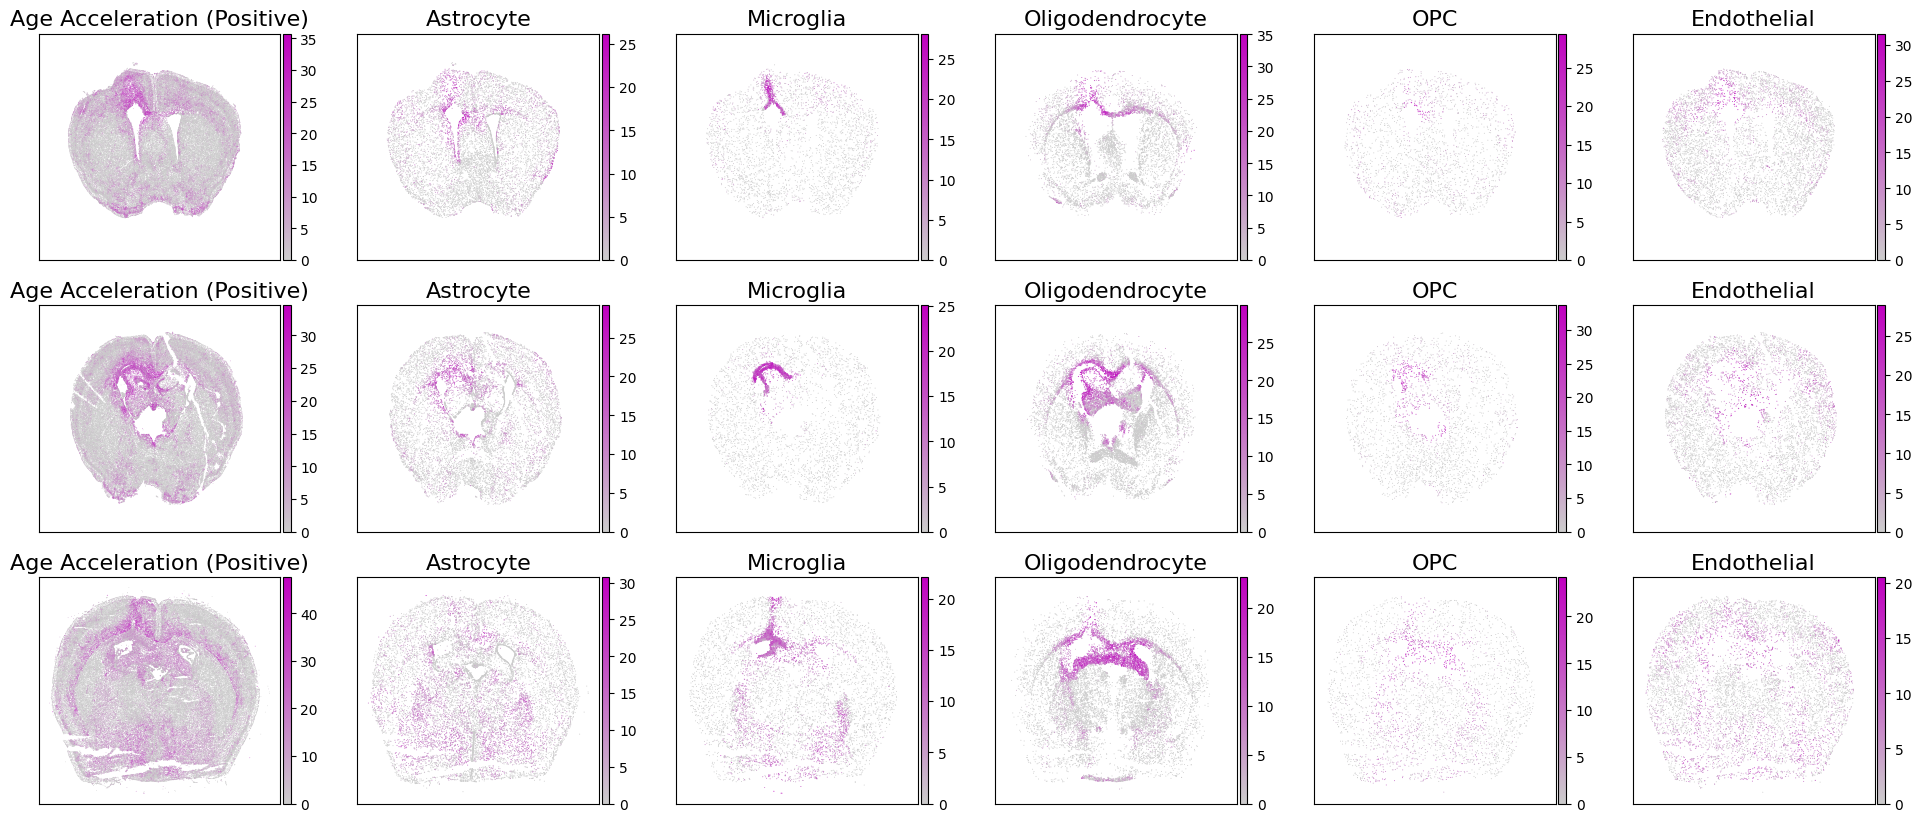

In [25]:
# Spatial Plotting

sc._settings.settings._vector_friendly=True

show_celltypes = ["Astrocyte", "Microglia", "Oligodendrocyte", "OPC",
                  "Endothelial"]

nrows = 3
ncols = len(show_celltypes)+1

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols,10), sharex=True, sharey=True)

for i in range(nrows):
    
    sub_adata = adata[adata.obs.replicate==np.unique(adata.obs.replicate)[i]]
    
    for j in range(ncols):
        
        # make plot with all cells
        if j == 0:
            sc.pl.embedding(sub_adata, "spatial",
                            color="positive_age_acceleration",
                            cmap=cmap2, size=1,
                            ax = axs[i,j], show=False)
            
            axs[i,j].set_title("Age Acceleration (Positive)", fontsize=16)
        
        # make plot by cell type
        else:
            sc.pl.embedding(sub_adata[sub_adata.obs.celltype==show_celltypes[j-1]], "spatial",
                            color="positive_age_acceleration",
                            cmap=cmap2, size=2,
                            ax = axs[i,j], show=False)
            
            axs[i,j].set_title(show_celltypes[j-1], fontsize=16)
            
        axs[i,j].set_xlabel(None)
        axs[i,j].set_ylabel(None)
        
        
plt.savefig("plots/clocks/spatial_positive_ageaccel_androvic_injury_paneled.pdf", bbox_inches='tight', dpi=300)
plt.show()